# Symulowane wyżarzanie

Algorytm symulowanego wyżarzania polega na poszukiwaniu przybliżonego rozwiązania problemu poprzez minimalizację pewniej funkcji energii E(s), która zależy od stanu s. Każdy krok algorytmu wyżarzania składa się z nastęujących punktów:  
- Wygeneruj stan sąsiedni - $s'$  
- Zaakceptuj stan sąsiedni w zależności od pewnej funckji prawdopodobieństwa $P(E(s), E(s'), T)$ (gdzie T to aktualna temperatura)  
$ $  
  
W poniższej implementacji funcja P:  
- zwraca prawdopodobieństwo 1 dla $E(s')>E(s)$  
- wpp. zwraca T (temperatura leży w zakresie od 0 do 1)

In [2]:
import numpy as np
from numpy.random import normal, uniform
import matplotlib.pyplot as plt
from random import random, randint, choice
from collections import defaultdict
from itertools import permutations, product
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import IPython.display as display
from PIL import Image
from os import listdir

## Travelling Salesman Problem (problem komiwojażera)

### Implementacja i używane zbiory punktów

Generatory punktów (2D) użytych do testowania:  
- `uni_points(n)` - `n` równomiernie rozłożonych punktów  
- `norm_points(n, m=0, std=1.5)` - `n` punktów rozłożonych zgodnie z rozkładem normalnym o średniej `m` i odchyleniu standardowym `std`
- `norm_groups(n, std=0.3)` - 9 równolicznych grup punktów. Każda grupa rozłożona jest zgodnie z rozkładem normalnym, a jej liczność to `n // 9`

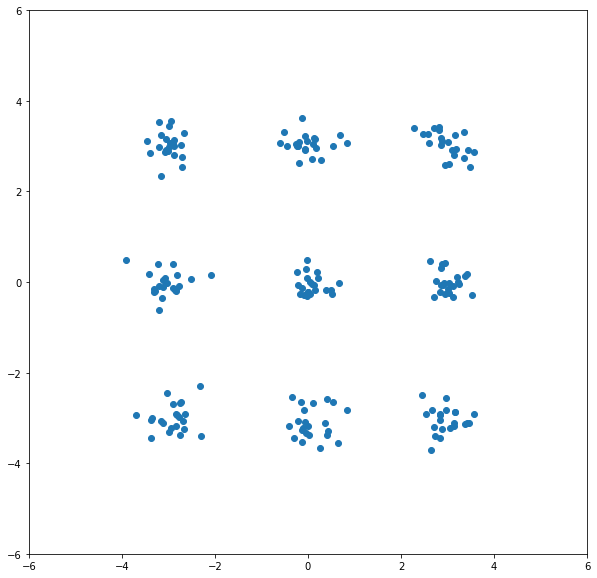

In [3]:
def generate_points(x_dist, y_dist):
    x = x_dist()[:, None]
    y = y_dist()[:, None]
    return np.concatenate([x,y], axis=1)

def draw(points, set_fig=True):
    if set_fig:
        plt.figure(figsize=(10,10))
    plt.xlim(left=-6, right=6)
    plt.ylim(bottom=-6, top=6)
    plt.scatter(points[:,0], points[:,1])
    
def uni_points(n):
    generator = lambda: uniform(-5, 5, n)
    points = generate_points(generator,generator)
    return points

def norm_points(n, m=0, std=1.5):
    generator = lambda: normal(0, std, n)
    points = generate_points(generator,generator)
    return points

def norm_groups(n, std=0.3):
    g_size = n // 9
    generators = [lambda: normal(-3, std, g_size), lambda: normal(0, std, g_size),
                  lambda: normal(3, std, g_size)]
    points = []
    for gen_x in generators:
        for gen_y in generators:
            points.append(generate_points(gen_x, gen_y))
    return np.concatenate(points, axis=0)

draw(norm_groups(200))

Funkcja `get_target(points, cycle)` jest funkcją energii - zwraca łączną długość aktualnego rozwiązania.

In [4]:
def get_target(points, cycle):
    """
        calculates length of cycle
        points: np.array (n, 2)
        cycle: list of indexes
    """
    n = points.shape[0]
    idx1 = cycle
    idx2 = np.roll(cycle,1, axis=0)
    diff = points[idx1,:] - points[idx2,:]
    return np.sum(np.sqrt(np.sum((diff)**2, axis=1)))
    
# przykad, kwadrad o wymiarach 2x2
c = np.array([0,2,3,1])
a = np.array([[0,0],[0,2],[2,0], [2,2]])
get_target(a, c)

8.0

Funckja `annealing(points, k, random_swap=True, temp_calc=None, save_targets=False)` zawiera implementację algorytmu symulowanego wyżarzania.  
- `k` - ilosć kroków    
- `random_swap` - mówi czy sąsiednie stany generować przez zamianę kolejności dwóch losowych punktów (True), czy dwóch sąsiadujących punktów (False)  
- `temp_calc` - funkcja obliczająca aktualną temperaturę w zależności od aktualnego kroku i ich łącznej liczby `k`. Spadek temperatury jest domyślnie liniowy.  

In [5]:
def annealing(points, k, random_swap=True, temp_calc=None, save_targets=False):
    if temp_calc is None:
        temp_calc = lambda i, k: 1 - i/k
    n = points.shape[0]
    state = np.array([i for i in range(n)]) # cycle with all points
    old_target = get_target(points, state)
    targets = [old_target]
    a, b = 0, 1
    for i in range(1, k+1):
        temp = temp_calc(i, k)
        # calculate potential new state (2 ways)
        if random_swap:
            a, b = randint(0, n-1), randint(0, n-1)
        else:
            a, b = (a + 1) % n, (b + 1) % n 
        state[a], state[b] = state[b], state[a]
        
        # calculate target
        target = get_target(points, state) 
        if save_targets:
            targets.append(target)
        if target > old_target and random() > temp: # temp too low to accept worse solution
            state[a], state[b] = state[b], state[a] # reject
        else:
            old_target = target # accept
    if save_targets:
        return state, targets
    return state

def draw_solution(points, solution, set_fig=True):
    draw(points, set_fig)
    plt.plot(points[solution,0], points[solution,1])
    f, l = solution[0], solution[-1]
    plt.plot(points[[f, l], 0], points[[f, l], 1], 'C0')
    
def sigmoid_temp(i, k):
    x = (i/k)*12
    return 1/(1 + np.exp(x))

### Przykład działania

Przykładowe uzyskane wyniki znajdują się poniżej.  
- użyta funkcja temperatury jest wycinkiem funkcji sigmoid.   
- ilość wykonanych w algorytmie kroków to 30000.  
- sąsiednie stany są generowane przez zmianę kolejności dwóch losowych punktów.  

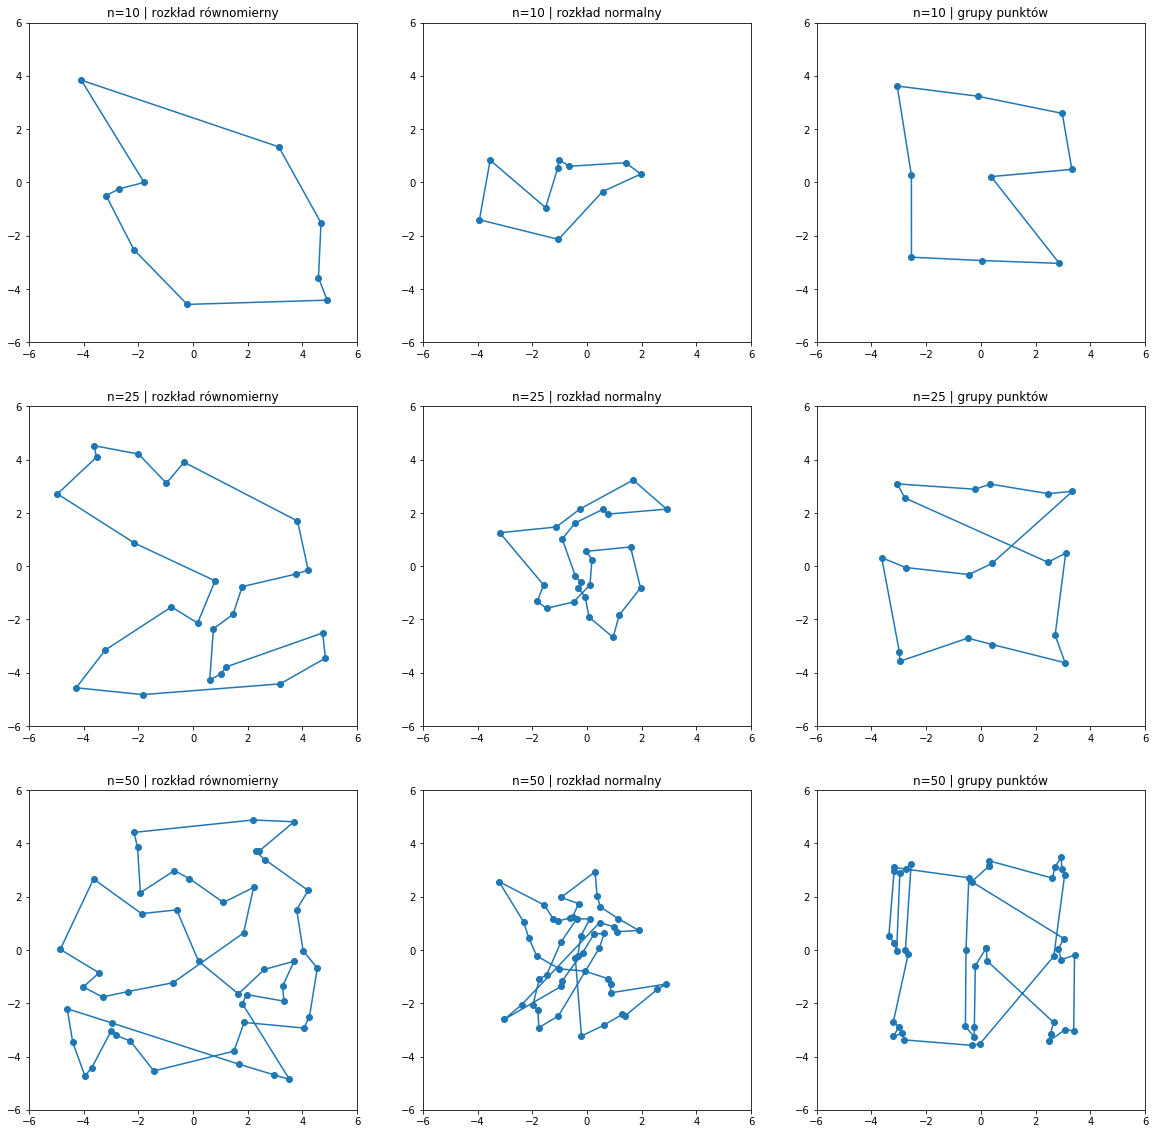

In [6]:
sizes = [10, 25, 50]
k = 30000

plt.figure(figsize=(20,20))
        
for i, n in enumerate(sizes):
    plt.subplot(3, 3, 3*i + 1)
    plt.title(f"n={n} | rozkład równomierny")
    points = uni_points(n)
    solution = annealing(points, k, random_swap=True, temp_calc=sigmoid_temp)
    draw_solution(points, solution, False)
    
    plt.subplot(3, 3, 3*i + 2)
    plt.title(f"n={n} | rozkład normalny")
    points = norm_points(n)
    solution = annealing(points, k, random_swap=True, temp_calc=sigmoid_temp)
    draw_solution(points, solution, False)
    
    plt.subplot(3, 3, 3*i + 3)
    points = norm_groups(n)
    plt.title(f"n={n} | grupy punktów")
    solution = annealing(points, k, random_swap=True, temp_calc=sigmoid_temp)
    draw_solution(points, solution, False)

### Wpływ sposobu generacji sąsiednich stanów  i funkcji temperatury na zbieżność

In [7]:
def slow_end(i, k):
    t = i/k
    if t < 0.1:
        return 0.9
    if t < 0.2:
        return 0.7
    if t < 0.3:
        return 0.5
    return (1 - t)/1.4

def slowest(i, k):
    return (1 - i/k)/2

Testowane funckje temperatury:  
- liniowa (opadająca od 1 do 0)  
- `slowest` - liniowa opadająca od 0.5 do 0  
- `slow_end` - przebieg funkcji przedstawiony na rysunku  
![temp function](weird_temp.png "slow_end")
- `sigmoid_temp` - wycinek odbitej względem osi y funkcji sigmoid
![temp function](sigmoid_temp.png "sigmoid_temp")

Sposoby generacji sąsiednich stanów i funkcje temperatury zostaną porównane przez sprawdzenie średnich uzyskanych wyników dla 27 punktów (10000 iteracji). Użyty zbiór punktów jest rozłożony zgodnie z rozkładem jednostajnym (podobne wyniki zostały uzyskane także dla pozostałych rozkładów).

In [ ]:
n = 27
k = 10000

results = defaultdict(lambda: [])
points = uni_points(n)

for i in tqdm(range(10), position=0):
    solution = annealing(points, k, random_swap=False)
    target = get_target(points, solution)
    results["consecutive swap, linear temp"].append(target)
    
    solution = annealing(points, k, random_swap=True)
    target = get_target(points, solution)
    results["arbitrary swap, linear temp"].append(target)
    
    solution = annealing(points, k, random_swap=False, temp_calc=sigmoid_temp)
    target = get_target(points, solution)
    results["consecutive swap, sigmoid temp"].append(target)
    
    solution = annealing(points, k, random_swap=True, temp_calc=sigmoid_temp)
    target = get_target(points, solution)
    results["arbitrary swap, sigmoid temp"].append(target)
    
    solution = annealing(points, k, random_swap=False, temp_calc=slow_end)
    target = get_target(points, solution)
    results["consecutive swap, slow end temp"].append(target)
    
    solution = annealing(points, k, random_swap=True, temp_calc=slow_end)
    target = get_target(points, solution)
    results["arbitrary swap, slow end temp"].append(target)
    
    solution = annealing(points, k, random_swap=False, temp_calc=slowest)
    target = get_target(points, solution)
    results["consecutive swap, slow temp"].append(target)
    
    solution = annealing(points, k, random_swap=True, temp_calc=slowest)
    target = get_target(points, solution)
    results["arbitrary swap, slow temp"].append(target)
    
for key, data in results.items():
    print(f"{key} | mean: {np.mean(data)} | std: {np.std(data)}")

Uzyskane wyniki (wartości funkcji energii):

Funkcja temperatury | Generacja sąsiadów | średni wynik | std
--- | --- | --- | --- 
liniowa (1-0) | consecutive swap | 76.5 | 7.5 
liniowa (1-0) | arbitrary swap | 64 | 6.5
liniowa (0.5-0) | consecutive swap | 74 | 5
liniowa (0.5-0) | arbitrary swap | 63 | 6
slow_end | consecutive swap | 73.7 | 6.6
slow_end | arbitrary swap | 62.6 | 4.5
sigmoid | consecutive swap | 73.6 | 9.6
sigmoid | arbitrary swap | 49.5 | 3


Uzyskane wyniki pozwalają zaobserwować, że najlepszą zbieżność (najniższy wynik i std) osiąga funkcja temperatury sigmoid i generowanie sąsiadów przez zamienianie losowych elementów.   
  
   
Poniżej znajduje się porównanie aktualnej energii w zależności od kroku algorytmu dla dwóch funkcji temperatury (liniowej (0.5-0) i sigmoid).

In [14]:
n = 20
k = 1000

results = defaultdict(lambda: [])
points = uni_points(n)

for i in tqdm(range(1000), position=0):
    _, targets = annealing(points, k, random_swap=True, temp_calc=sigmoid_temp, save_targets=True)
    results["sigmoid temp"].append(targets)
    
    _, targets = annealing(points, k, random_swap=True, temp_calc=slowest, save_targets=True)
    results["linear temp"].append(targets)

x = np.arange(0,k+1)
sigmoid_res = np.array([t for t in results["sigmoid temp"]])
lin_res = np.array([t for t in results["linear temp"]])
mean_sig = np.mean(sigmoid_res, axis=0)
mean_lin = np.mean(lin_res, axis=0)
std_sig = np.std(sigmoid_res, axis=0)
std_lin = np.std(lin_res, axis=0)

100%|██████████| 1000/1000 [02:13<00:00,  7.47it/s]


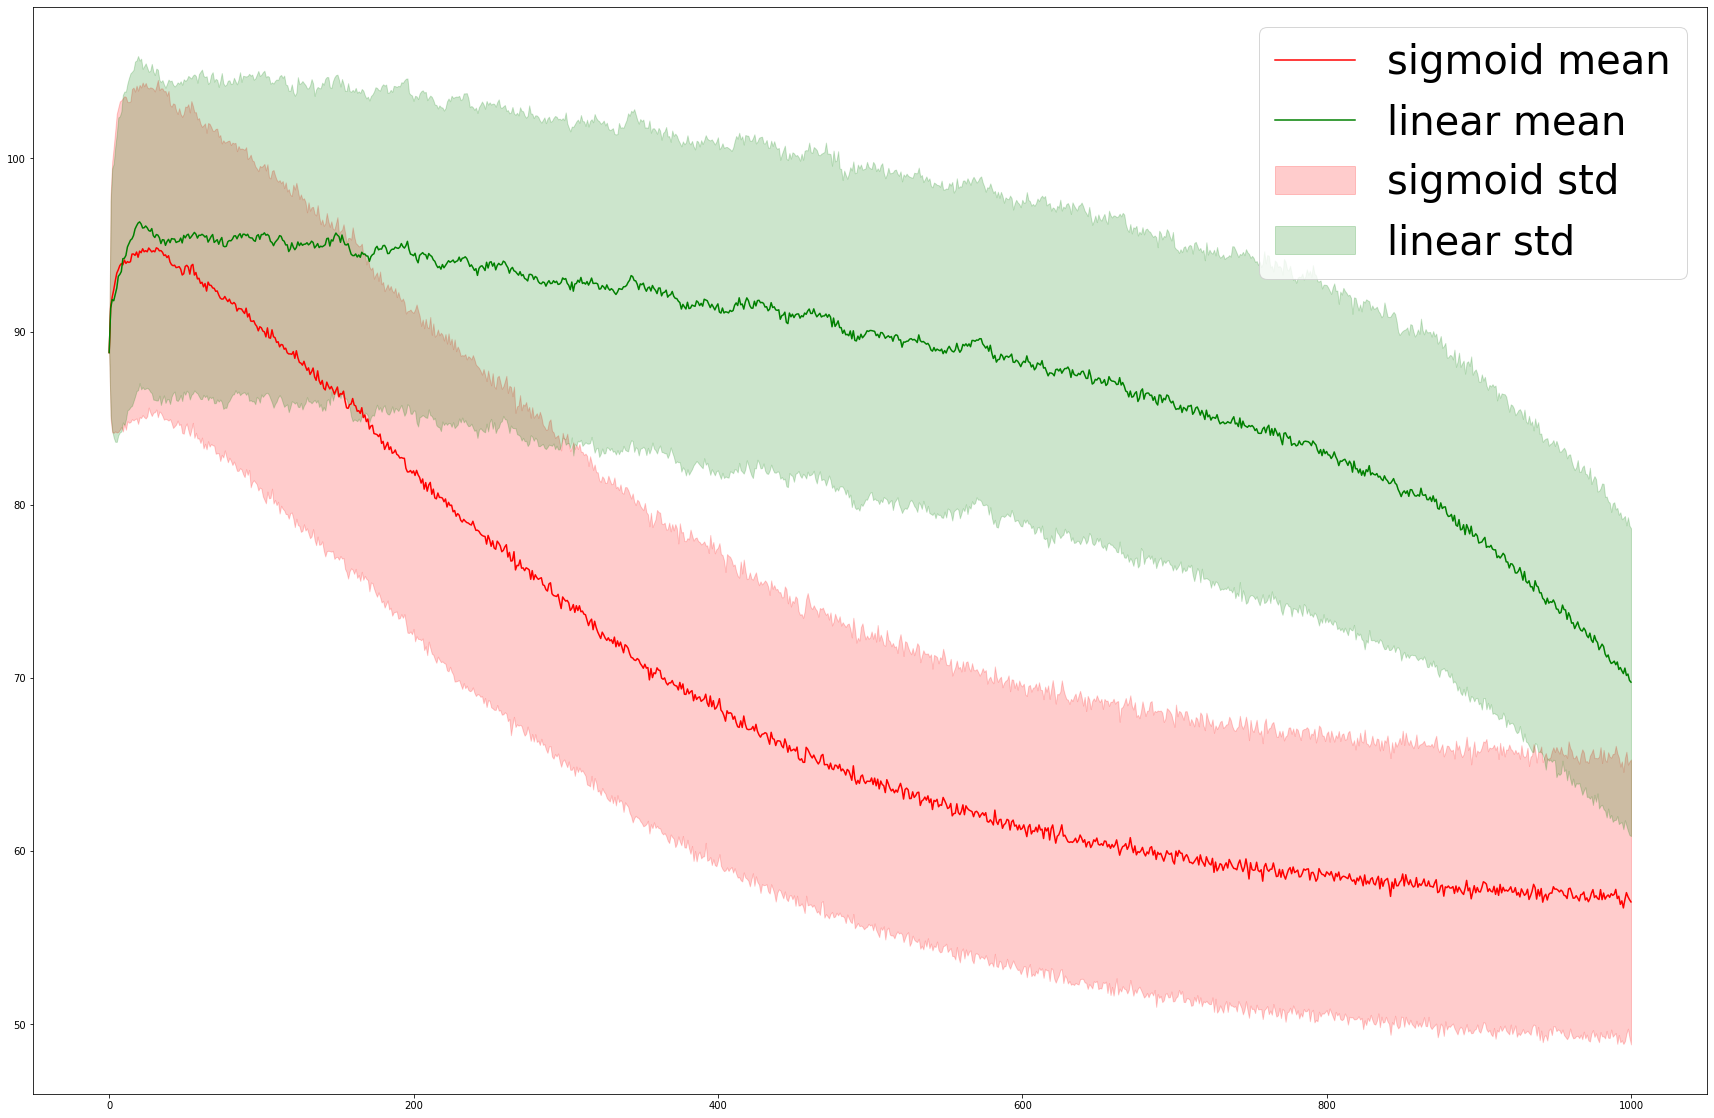

In [15]:
plt.figure(figsize=(30,20))
plt.plot(x, mean_sig, 'r', label="sigmoid mean")
plt.fill_between(x, mean_sig-std_sig,mean_sig+std_sig, color='r', alpha=0.2, label="sigmoid std")
plt.plot(x, mean_lin, 'g', label="linear mean")
plt.fill_between(x, mean_lin-std_lin,mean_lin+std_lin, color='g', alpha=0.2, label="linear std")
plt.legend(fontsize=40)
plt.show()

Powyższy Wykres wyraźnie obrazuje, że przy temperaturze zmieniającej się zgodnie z funkcją sigmoid dobre wyniki są osiągane znacznie szybciej niż przy zmianach liniowych.  
  
 
Na poniższym wykresie znajduje się podobne porównanie, lecz z innym sposobem generowania sąsiadów (consequtive swap). Widać, że w takiej sytuacji lepszy wynik osiągnięty jest przy liniowej zmianie temperatury.   
Jest to spowodowane tym, że ze względu na sposób generowania sąsiadów możliwe jest utknięcie w lokalnym minimum funkcji energii. Dzieje się to przy zmianie temperatury zgodnej z funkcją sigmoid, gdyż temperatura spada zbyt szybko i stan rozwiązania nie ma czasu, aby znaleźć się w okolicy optymalnego rozwiązania. Funkcja liniowa unika tego problemu, ponieważ wiekość jej zmiany w każdym kroku iteracji jest stała.
![results with consequtive swap](annealing_con_swap.png "consequitive swap results")


### Wizualizacja działania algorytmu

In [ ]:
fig = plt.figure()
ax = plt.axes(xlim=(-6, 6), ylim=(-6, 6))
line, = ax.plot([], [], lw=3)

n = 50
k = 3000
points = uni_points(n)
n = points.shape[0] # in case of norm_groups number of points can slightly change
state = np.array([i for i in range(n)]) # cycle with all points
old_target = get_target(points, state)
targets = [old_target]

def init():
    line.set_data([], [])
    return line,

def animate(i):
    global old_target
    global state
    temp = sigmoid_temp(i, k)
    a, b = randint(0, n-1), randint(0, n-1)
    state[a], state[b] = state[b], state[a]
    target = get_target(points, state) 
    if target > old_target and random() > temp: # temp too low to accept worse solution
        state[a], state[b] = state[b], state[a] # reject
    else:
        old_target = target # accept
    x = np.append(points[state, 0], points[state[0], 0])
    y = np.append(points[state, 1], points[state[0], 1])
    line.set_data(x, y)
    plt.title(f"{i}/{k}")
    return line,

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=k, interval=20, blit=True)
HTML(anim.to_html5_video())

## Obraz binarny

Symulowane wyrzażanie dla obrazu binarnego zostanie przeprowadzone dla 4 różnych funkcji energii (3 bazują na względnym położeniu pikseli, 1 bazuje na masce wczytanej z pliku).  

- Funkcje energii bazujące na sąsiedztwie biorą pod uwagę różne ilości pobliskich pikseli (4,8,16), co zostało zwizualizowane poniżej. Dla każdego środkowego piksela "o":
  - każdy z jego sąsiadów "x" w tym samym kolorze co "o" zmniejsza łączną energię o 1, 
  - każdy sąsiad "x" w innym kolorze zwiększa ją o 1.
    
4|.|.|.|8|.|.|.|1|6|.|.|.
--- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | ---
.|.|.| .|.|.|.| .| x|.|x|.| x|
.|x|.| .|x|x|x| .| .|x|x|x| .|
x|o|x| .|x|o|x| .| x|x|o|x| x|
.|x|.| .|x|x|x| .| .|x|x|x| .|
.|.|.| .|.|.|.| .| x|.|x|.| x|


- Funkcja energii bazująca na masce zwiększa energię o 1 za każdy piksel niepokrywający się z maską.

Stany sąsiednie generowane będą na 2 sposoby:  
- zamiana miejscami losowej liczby(z zakresu \[1,10\]) sąsiadujących pikseli
- zamiana miejscami losowej liczby(z zakresu \[1,10\]) przypadkowych pikseli

Wszystkie funkcje służące do generowania i modyfikowania stanu obrazu, obliczania energii itd. znajdują się w klasie `binary_space`.

Wprowadzone zostaje kilka modyfikacji funkcji `annealing`, aby współpracowała poprawnie z klasą `binary_space`.

In [21]:
class binary_space():
    def __init__(self, n, weight=0.5):
        self.n = n
        im = Image.fromarray(np.loadtxt("mask"))
        im = im.resize((n,n))
        self.mask = np.array(im)
        self.mask = np.array(self.mask, dtype=np.uint8)
        self.space =  np.random.choice([0,1], (n, n), p=[1-weight, weight])
        self.space = np.array(self.space, dtype=np.uint8)
        self.copy = np.copy(self.space)
        self.diffrences = []
        self.possible_changes = [v for v in product([-1, 0,1], [-1, 0,1]) if v != (0,0)]
        self.four_neighbours = [(0,1), (1,0), (0,-1), (-1,0)]
        self.eight_neighbours = [v for v in product([-1, 0,1], [-1, 0,1]) if v != (0,0)]
        space = [-2, 0, 2]
        self.sixteen_neighbours = [v for v in product(space, space) if v != (0,0)] + self.eight_neighbours
        self.neighbour = self.consequtive_neighbour
        
    def set_random_neighbour(self):
        self.neighbour = self.random_neighbour
        
    def set_consequtive_neighbour(self):
        self.neighbour = self.consequtive_neighbour
        
    def energy(self, neighbours):
        E = 0
        for direction in neighbours:
            neighbour = np.roll(self.space, direction, axis=(0,1))
            same = neighbour == self.space
            E -= np.sum(same) # low energy with similar neighbours
            E += np.sum(np.logical_not(same)) # high energy with different neighbours
        return E
    
    def special_energy(self):
        return -np.sum(self.space == self.mask)
    
    def energy4(self):
        return self.energy(self.four_neighbours)
    
    def energy8(self):
        return self.energy(self.eight_neighbours)
    
    def energy16(self):
        return self.energy(self.sixteen_neighbours)

    def state(self):
        return self.space

    def consequtive_neighbour(self):
        diff_num = randint(1,10)
        self.diffrences = []
        for i in range(diff_num):
            pos_a = (randint(0, self.n-1), randint(0, self.n-1))
            vec = choice(self.possible_changes)
            pos_b = (pos_a[0] + vec[0], pos_a[0] + vec[0])
            pos_b = tuple(x if x < self.n else 0 for x in pos_b)
            if self.space[pos_a] == self.space[pos_b]: continue
            self.space[pos_a], self.space[pos_b] = self.space[pos_b], self.space[pos_a]
            self.diffrences.append((pos_a, pos_b))
            
    def random_neighbour(self):
        diff_num = randint(1,10)
        self.diffrences = []
        for i in range(diff_num):
            pos_a = (randint(0, self.n-1), randint(0, self.n-1))
            pos_b = (randint(0, self.n-1), randint(0, self.n-1))
            while pos_a == pos_b: pos_b = (randint(0, self.n-1), randint(0, self.n-1))
            self.space[pos_a], self.space[pos_b] = self.space[pos_b], self.space[pos_a]
            self.diffrences.append((pos_a, pos_b))
            
    def reset(self):
        self.space = np.copy(self.copy)
            
    def go_back(self):
        for pos_a, pos_b in self.diffrences[::-1]:
            self.space[pos_a], self.space[pos_b] = self.space[pos_b], self.space[pos_a]
    
    def draw(self, size=None):
        if size is None: size=(400,400)
        return Image.fromarray(self.space*255).resize(size)
    
    def plot(self):
        plt.imshow(np.asarray(self.draw()), cmap='Greys')

In [22]:
def annealing(space, k, temp_calc=None, save_targets=False, energy_fun=None):
    if energy_fun is None:
        energy_fun = space.energy4
    if temp_calc is None:
        temp_calc = lambda i, k: 1 - i/k
    n = points.shape[0]
    old_energy = energy_fun()
    targets = [old_energy]

    for i in range(1, k+1):
        temp = temp_calc(i, k)
        # calculate potential new state (2 ways)
        space.neighbour()
        energy = energy_fun()
        if save_targets:
            targets.append(target)
        if energy > old_energy and random() > temp: # temp too low to accept worse solution
            space.go_back() # reject
        else:
            old_energy = energy # accept
    if save_targets:
        return targets

### Przykładowe wyniki

#### 90% czarnych pikseli, różne funkcje energii i sposoby generacji sąsiadów

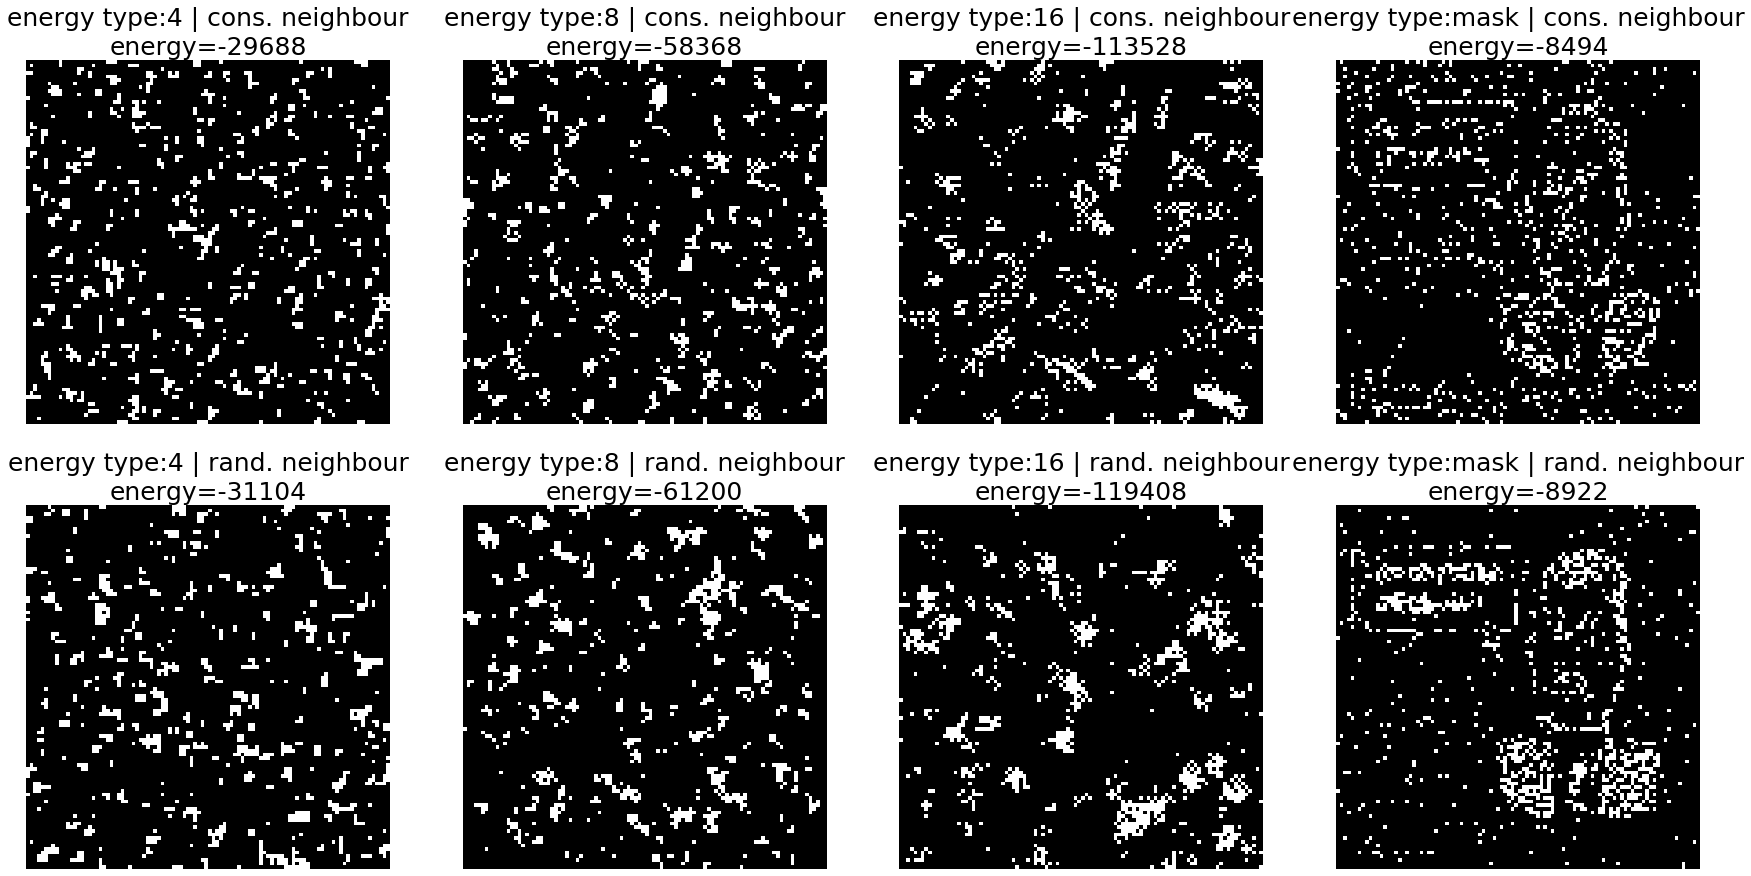

In [23]:
space = binary_space(100, 0.9)
plt.figure(figsize=(30,15))
k=20000
energy_name = {0: 4, 1: 8, 2:16, 3:"mask"}
for i, rand in enumerate([False, True]):
    if rand: 
        neighbour="rand."
        space.set_random_neighbour()
    else: 
        neighbour="cons."
        space.set_consequtive_neighbour()
    for j, energy in enumerate([space.energy4, space.energy8, 
                               space.energy16, space.special_energy]):
        
        space.reset()
        plt.subplot(2,4, (i*4 + j + 1))
        annealing(space, k, temp_calc=sigmoid_temp, energy_fun=energy)
        plt.title(f"energy type:{energy_name[j]} | {neighbour} neighbour\nenergy={energy()}", {"fontsize":25})
        plt.axis('off')
        space.plot()

#### 60% czarnych pikseli, różne funkcje energii i sposoby generacji sąsiadów

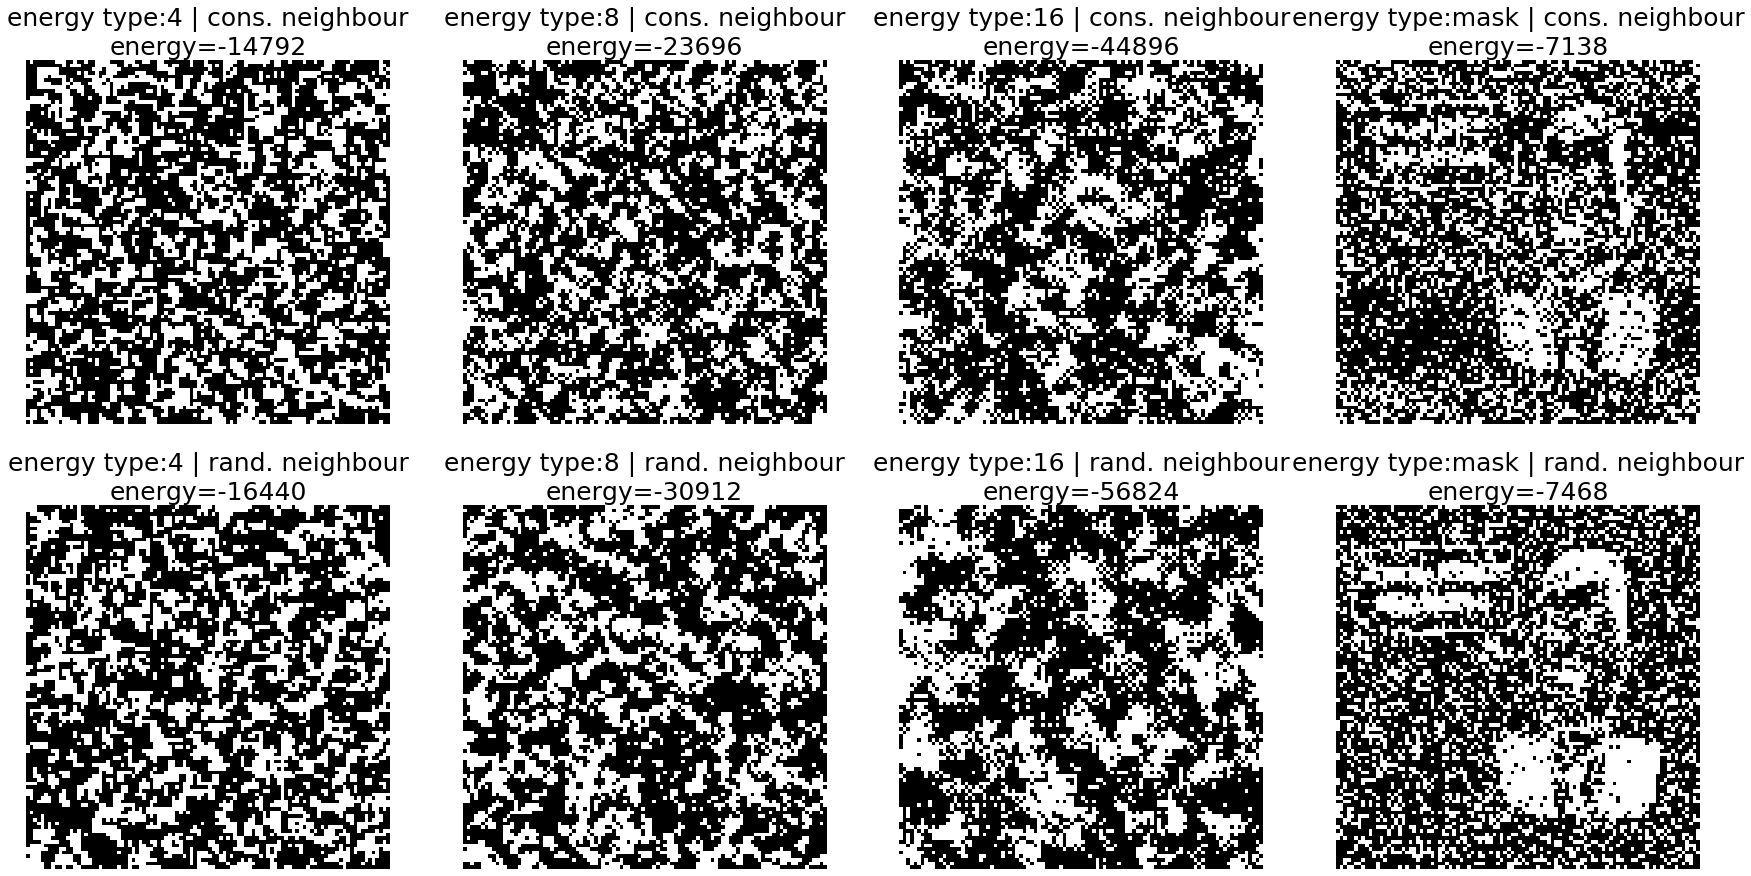

In [24]:
space = binary_space(100, 0.6)
plt.figure(figsize=(30,15))
k=20000
energy_name = {0: 4, 1: 8, 2:16, 3:"mask"}
for i, rand in enumerate([False, True]):
    if rand: 
        neighbour="rand."
        space.set_random_neighbour()
    else: 
        neighbour="cons."
        space.set_consequtive_neighbour()
    for j, energy in enumerate([space.energy4, space.energy8, 
                               space.energy16, space.special_energy]):
        
        space.reset()
        plt.subplot(2,4, (i*4 + j + 1))
        annealing(space, k, temp_calc=sigmoid_temp, energy_fun=energy)
        plt.title(f"energy type:{energy_name[j]} | {neighbour} neighbour\nenergy={energy()}", {"fontsize":25})
        plt.axis('off')
        space.plot()

#### 60% czarnych pikseli, różne funkcje temperatury i energii

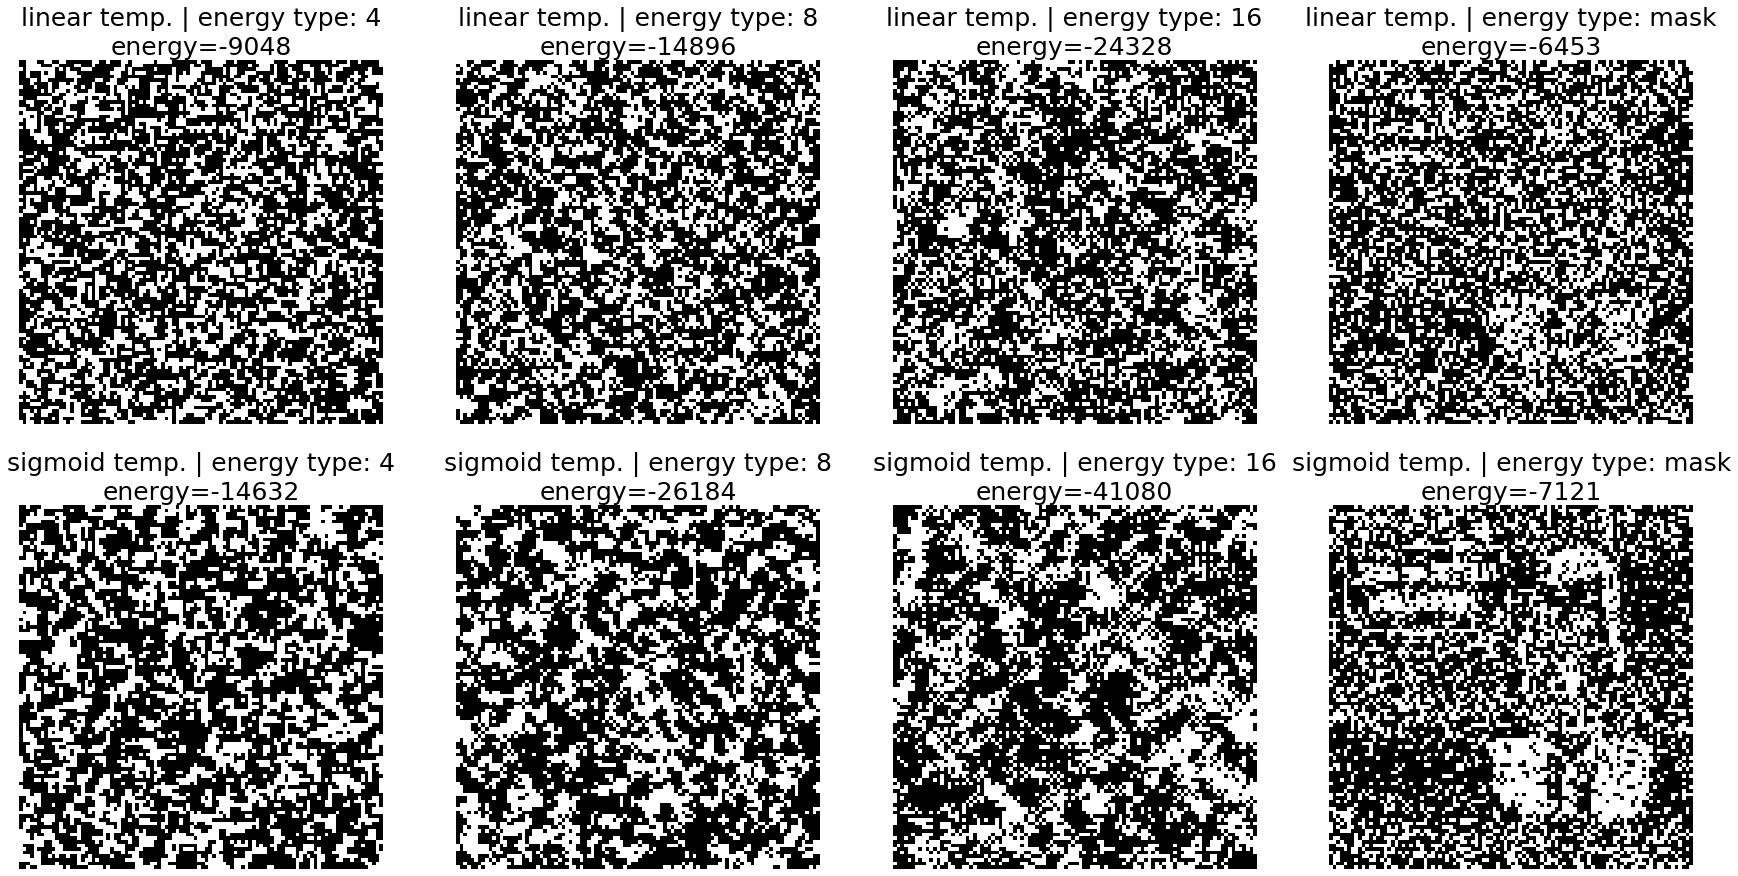

In [25]:
space = binary_space(100, 0.6)
plt.figure(figsize=(30,15))
k=20000
energy_name = {0: 4, 1: 8, 2:16, 3:"mask"}
for i, temp in enumerate([None, sigmoid_temp]):
    if temp is None: 
        t="linear"
    else: 
        t="sigmoid"
    for j, energy in enumerate([space.energy4, space.energy8, 
                               space.energy16, space.special_energy]):
        space.reset()
        plt.subplot(2,4, (i*4 + j + 1))
        annealing(space, k, temp_calc=temp, energy_fun=energy)
        plt.title(f"{t} temp. | energy type: {energy_name[j]}\nenergy={energy()}", {"fontsize":25})
        plt.axis('off')
        space.plot()

### Wpływ wybranych składowych na działanie algorytmu
- Funkcja energii - ma duży wpływ na wygląd ostatecznego wyniku, ponieważ jest to sposób na narzucenie algorytmowi oczekiwanego rezultatu. Funkcja ta jest najważniejszą składową w kwestii ustalenia trudności znalezienia rozwiązania, gdyż znalezienie minimum niektórych funkcji (np. funkcja maska) jest zdecydowanie prostsze niż innych.  
- Wybór stanu sąsiedniego - wraz z funkcją temperatury wpływa na to jakie wyniki mogą zostać osiągnięte. Niektóre sposoby wyboru mogą doprowadzić do częstego utykania w lokalnym minimum funkcji energii. Z porównywanych sposobów zamiana miejscami losowych pikseli osiąga najlepsze wyniki (takie zmiany unikają utknięcia w lokalnym minimum funkcji energii).  
- Funkcja temperatury - wpływ zbliżony do sposobu wyboru stanu sąsiedniego. Z porównanych funkcji znacząco lepsza okazała się funkcja oparta na sigmoidzie.

## Sudoku

Przy rozwiązywaniu sudoku metodą symulowanego wyżarzania przyjęto następujące parametry:
- stan początkowy to plansza całkowicie wypełniona liczbami w taki sposób, że w każdym z 9 małych kwadratów 3x3 znajdują się wszystkie liczby od 1 do 9  
- stan sąsiedni jest generowany przez zamianę dwóch liczb w jednym kwadracie  
- początkowo zapełnione pola nie zmieniają się  
- funkcja temperatury: `sigmoid_temp`

50 przykładowych plansz znajduje się w folderze `sudoku`. Można je załadować funkcjami `load_sudoku(filename)` i `load_all()`

Stan planszy jest przechowywany i modyfikowany przy pomocy klasy `sudoku`, która posiada funkcje do generowania sąsiada (`neighbour`), powrotu do stanu poprzedniego (`go_back`) i obliczania energii (`energy`).

In [26]:
def load_sudoku(filename):
    with open(filename, "r") as file:
        sudoku = file.read().split()
        sudoku = [list(map(lambda x: -1 if x=="x" else int(x),line)) for line in sudoku]
    return np.array(sudoku, dtype=np.int8)

def load_all():
    sudoku_list = []
    for filename in listdir("sudoku"):
        sudoku_list.append(load_sudoku(f"./sudoku/{filename}"))
    return sudoku_list
sudoku_list = load_all()

In [27]:
class sudoku():
    def __init__(self, board):
        self.board = np.copy(board)
        self.mask = board == -1 # all numbers that can be changed
        self.fill_empty()
        self.changeable = np.stack(np.where(self.mask)).transpose()
        self.change = None
        
    def fill_empty(self):
        for i in range(3):
            for j in range(3):
                idx_i = 3*i
                idx_j = 3*j
                lacking = set(i for i in range(1,10))
                board_part = self.board[idx_i:idx_i+3, idx_j:idx_j+3]
                values = set(board_part.flatten()) - set([-1])
                lacking -= values
                board_part[self.mask[idx_i:idx_i+3, idx_j:idx_j+3]] = np.array(list(lacking))
                
    def energy(self):
        E = 0
        for axis in [0, 1]: 
            for i in range(1, 5):
                E += np.sum(self.board == np.roll(self.board, i, axis=axis))
        return E
    
    def neighbour(self):
        first = randint(0, self.changeable.shape[0]-1)
        first_idx = tuple(self.changeable[first])
        square =  self.get_square(self.changeable[first])
        square_idx = np.zeros((9,9), dtype=np.bool)
        square_idx[3*square[0]:3*square[0]+3, 3*square[1]:3*square[1]+3] = True
        changable_square_idx = np.logical_and(self.mask, square_idx)
        changable_square_idx[first_idx] = False
        changeable_square = np.stack(np.where(changable_square_idx)).transpose()
        second = randint(0, changeable_square.shape[0]-1)
        second_idx = tuple(changeable_square[second])
        self.change=[first_idx, second_idx]
        self.board[first_idx], self.board[second_idx] = self.board[second_idx], self.board[first_idx]
    
    def go_back(self):
        first_idx = self.change[0]
        second_idx = self.change[1]
        self.change=[]
        self.board[first_idx], self.board[second_idx] = self.board[second_idx], self.board[first_idx]
    
    @staticmethod
    def get_square(place):
        return (place[0]//3, place[1]//3)
    
example = sudoku(sudoku_list[0])
example.board

array([[2, 4, 3, 1, 2, 5, 1, 5, 2],
       [5, 6, 1, 9, 4, 3, 6, 4, 7],
       [7, 8, 9, 6, 7, 8, 3, 8, 9],
       [6, 2, 4, 1, 5, 3, 1, 3, 2],
       [1, 5, 3, 4, 6, 7, 5, 4, 6],
       [8, 7, 9, 8, 2, 9, 8, 9, 7],
       [1, 4, 5, 1, 2, 5, 2, 1, 3],
       [6, 7, 2, 4, 3, 6, 7, 5, 6],
       [8, 3, 9, 7, 8, 9, 8, 4, 9]], dtype=int8)

Do znalezienia rozwiązania wykorzystana jest wcześniej zdefiniowana funkcja `annealing`. Przykładowy wynik znajduje sie poniżej.

In [28]:
annealing(example, 35000, temp_calc=sigmoid_temp, save_targets=False, energy_fun=example.energy)
print(f"energy: {example.energy()}\nboard:\n{example.board}")

energy: 0
board:
[[3 4 8 2 6 7 9 5 1]
 [5 7 1 9 4 3 6 2 8]
 [2 6 9 1 8 5 3 7 4]
 [6 9 7 3 5 1 4 8 2]
 [1 2 3 8 7 4 5 9 6]
 [8 5 4 6 2 9 1 3 7]
 [4 1 5 7 9 8 2 6 3]
 [9 8 2 4 3 6 7 1 5]
 [7 3 6 5 1 2 8 4 9]]


### Liczba iteracji potrzebna do znalezienia rozwiązania

Aby wyznaczyć przybliżoną średnią liczbę iteracji potrzebną na rozwiązanie planszy o danej ilości pól pustych, zostanie sprawdzone czy rozwiązanie jest znajdywane w pewnych konkretnych ilościach iteracji (w zakresie od 1500 do 20000). Każdy test zostanie przeprowadzony 5 razy.

In [ ]:
sizes = set()
count = defaultdict(lambda: [])
for board in sudoku_list:
    size = np.sum(board==-1)
    if size not in sizes:
        print(f"size={size}")
        sizes.add(size)
        for i in range(5):
            k = 1500
            while True:
                game = sudoku(board)
                annealing(game, k, temp_calc=sigmoid_temp, save_targets=False, energy_fun=game.energy)
                if game.energy() == 0:
                   # print(f"size={size} | iterations={k}")
                    count[size].append(k)
                    break
                if k>=20000:
                   # print(f"size={size} | no solution found | {game.energy()} energy for k={k}")
                    break
                if k<3000:
                    k += 500
                elif k < 6000:
                    k += 1000
                else:
                    k +=2000

In [30]:
print(f"no solution for: {sizes - set([k for k in count.keys()])}")
for k, v in count.items():
    print(f"for size={k} solution was found in {len(v)} out of 5 tries")

no solution for: {56, 57, 58, 59}
for size=53 solution was found in 4 out of 5 tries
for size=51 solution was found in 5 out of 5 tries
for size=55 solution was found in 1 out of 5 tries
for size=54 solution was found in 3 out of 5 tries
for size=49 solution was found in 5 out of 5 tries
for size=45 solution was found in 5 out of 5 tries
for size=50 solution was found in 5 out of 5 tries
for size=52 solution was found in 5 out of 5 tries


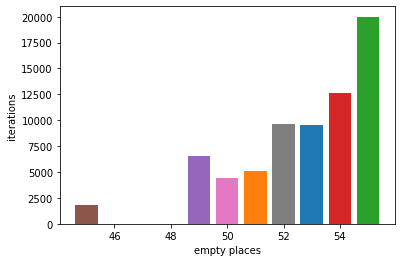

In [31]:
s = []
plt.ylabel("iterations")
plt.xlabel("empty places")
for k, v in count.items():
    plt.bar(k, np.mean(v))

Rozwiązanie nie zostało znalezione dla każdej planszy, lecz algorytm powinien być w stanie to zrobić przy odpowiednio dużej ilości iteracji. Wraz z rosnącą ilością pustych pól rozwiązanie jest znajdowane coraz rzadniej (przy narzuconej maksymalnej ilości iteracji), gdyż średnia ilość potrzebnych iteracji zwiększa się.  
Zależność pomiędzy ilością pustych pól, a liczbą potrzebnych iteracji wydaje się być w przybliżeniu liniowa, lecz trudno to jednoznacznie określić - ważne mogą być także inne czynniki (np. konkretne ustawienie liczb na planszy). Żeby jednoznacznie określić tą zależnosć  należałoby sprawdzić plansze z większego zakresu pustych pól i dla każdej ilości pustych pól znaleźć wymaganą liczbę iteracji dla np. 10 różnych planszy.  